In [1]:
import numpy as np
import matplotlib.pyplot as plt
#import treecorr
import healpy as hp
import astropy.io.fits as afits


In [5]:
gal_data = afits.open(
    "y3a2_gold2.2.1_redmagic_highdens.fits"
)[1].data
print(gal_data.dtype.names)
('coadd_object_id', 'ra', 'dec', 'zredmagic', 'zredmagic_e', 'mag_z', 'lum_z', 'zredmagic_samp_0', 'zredmagic_samp_1', 'zredmagic_samp_2', 'zredmagic_samp_3', 'weight', 'bin_number')

mask = hp.read_map("y3_gold_2.2.1_RING_joint_redmagic_v0.5.1_wide_maglim_v2.2_mask.fits",
partial=True
)
mask[mask<0]=0.
nside=hp.npix2nside(len(mask))

('coadd_object_id', 'ra', 'dec', 'zredmagic', 'zredmagic_e', 'mag_z', 'lum_z', 'zredmagic_samp_0', 'zredmagic_samp_1', 'zredmagic_samp_2', 'zredmagic_samp_3', 'weight', 'bin_number')


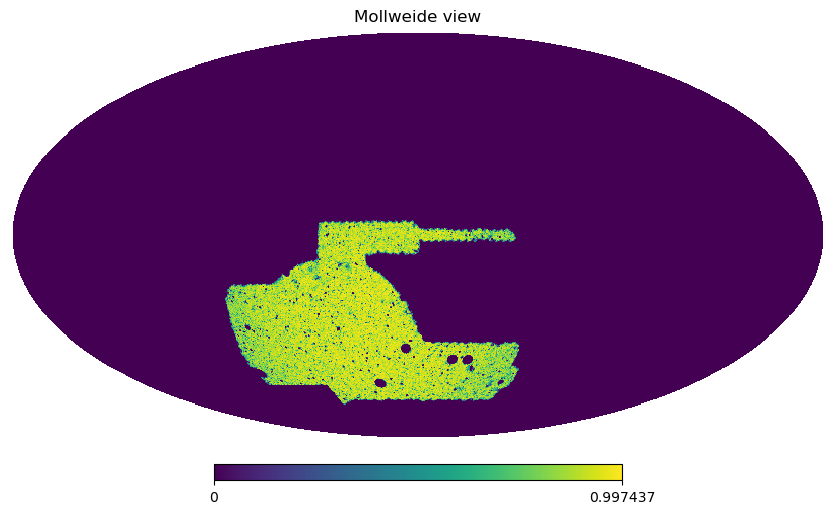

In [6]:
%matplotlib inline

hp.mollview(hp.ud_grade(mask, 256))

In [7]:
gal_map = np.zeros(hp.nside2npix(nside))
gal_theta = np.pi/2 - np.radians(gal_data["dec"])
gal_phi = 2*np.pi - np.radians(gal_data["ra"])
gal_pix_inds = hp.ang2pix(nside, gal_data["ra"], gal_data["dec"], lonlat=True)
np.add.at(gal_map,gal_pix_inds,gal_data["weight"]) 

In [8]:
dg_bar = np.sum(gal_map*mask)/np.sum(mask)
print("galaxy density per pixel = %.2e"%dg_bar)
print("galaxy density per square degree = %.1f"%(dg_bar/hp.nside2pixarea(nside, degrees=True)))
dg_map = (gal_map-dg_bar)/dg_bar

galaxy density per pixel = 8.66e-02
galaxy density per square degree = 422.5


The moon is about half a degree in diameter (so ~400 galaxies per ~5 moons)

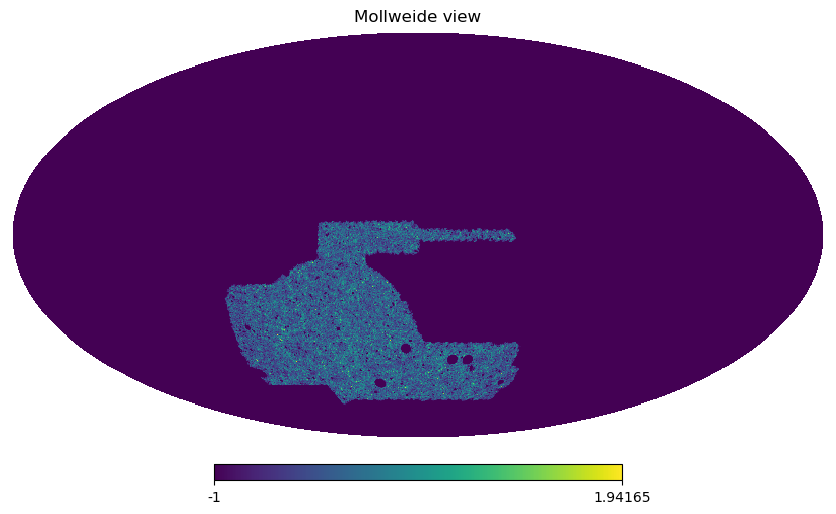

In [9]:
%matplotlib inline

hp.mollview(hp.ud_grade(dg_map, 256))

Read in kappa map (inferred from galaxy shapes)

In [10]:
k_map_zhi = hp.read_map("KS_tomo4.fits")
k_map_zlo = hp.read_map("KS_tomo3.fits")

In [11]:
#And cross-correlate

In [12]:
cl_dg_khi = hp.anafast(dg_map, k_map_zhi, lmax=2000)
cl_dg_klo = hp.anafast(dg_map, k_map_zlo, lmax=2000)

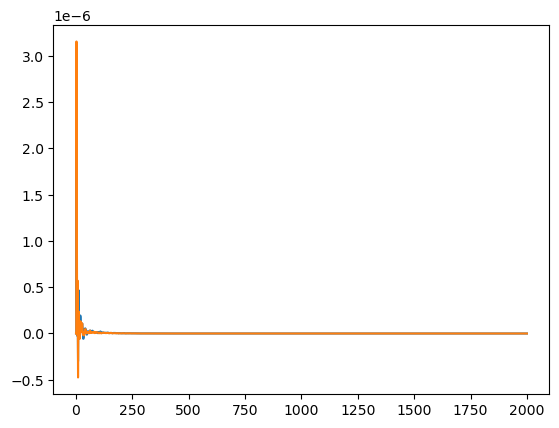

In [15]:
%matplotlib inline

fig,ax=plt.subplots()

ax.plot(cl_dg_khi)
ax.plot(cl_dg_klo)

In [16]:
class ClBinner(object):
    """
    Class for binning Cls in equal
    width bins, weighting by 2L+1
    """
    def __init__(self, lmin=100, lmax=1000, nbin=20, log=False):
        self.lmin=lmin
        self.lmax=lmax
        self.nbin=nbin
        if log:
            log_bin_lims = np.linspace(
                np.log(lmin), np.log(lmax), nbin+1)
            #need to make this integers
            bin_lims = np.ceil(np.exp(log_bin_lims))
            log_bin_lims = np.log(bin_lims)
            log_bin_mids = 0.5*(log_bin_lims[:-1]+log_bin_lims[1:])
            self.bin_lims = np.exp(log_bin_lims).astype(int)
            self.bin_mids = np.exp(log_bin_mids)
        else:
            self.bin_lims = np.ceil(np.linspace(
                self.lmin, self.lmax+1, self.nbin+1
            )).astype(int)
            self.bin_mids = 0.5*(self.bin_lims[:-1]
                                 +self.bin_lims[1:])
        self.deltal = np.diff(self.bin_lims)
        
    def __call__(self, cl):
        L = np.arange(len(cl)).astype(int)
        w = 2*L+1
        cl_binned = np.zeros(self.nbin)
        for i in range(self.nbin):
            use = (L>=self.bin_lims[i])*(L<self.bin_lims[i+1])
            cl_binned[i] = np.average(cl[use], weights=w[use])
        return cl_binned

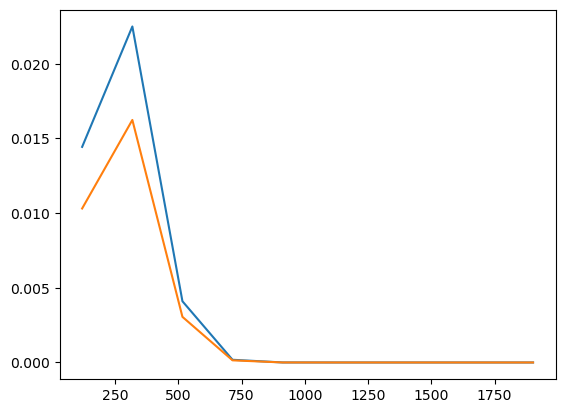

In [20]:
%matplotlib inline

fig,ax=plt.subplots()

binner=ClBinner(lmin=20,lmax=2000,nbin=10)

ax.plot(binner.bin_mids, binner.bin_mids**3*binner(cl_dg_khi))
ax.plot(binner.bin_mids, binner.bin_mids**3*binner(cl_dg_klo))

Theory prediction. A few definitions:
- $\chi(z)$ = (comoving) radial distance to redshift $z$. Can relate to Hubble constant and density components of the Universe:
   $\chi(z) = \frac{c}{H_0} \int_0^{z} dz' (\Omega_m(1+z)^3 + \Omega_k(1+z)^2 + \Omega_{\Lambda})^{0.5}$
- $n_{\mathrm{lens}}(z)$ = number density of lens galaxies as a function of redshift (normalized to 1). We're going to assume we can treat lenses being at a single redshift $n_{\mathrm{lens}}(z) = \delta_D(z-z_{\mathrm{lens}})$
- $n_{\mathrm{source}}(z)$ = number density of source galaxies as a function of redshift (normalized to 1)

Then power spectrum between galaxy-overdensity and $\kappa$ is:

$C_l^{g\kappa} = \frac{3}{2}\Omega_m H_0 \int d\chi \frac{n_{\mathrm{lens}}(\chi) W_\kappa(\chi)}{a(\chi)} P_{gm}(k=l/\chi, \chi)$\

Lensing kernel (for flat Universe)
$W_{\kappa}(\chi) = \frac{1}{\chi}\int_{\chi}^{\infty} d\chi' n_{\kappa}(\chi) \frac{\chi-\chi'}{\chi'}$

and substitute $n_{\mathrm{lens}}(z) = \delta_D(z-z_{\mathrm{lens}})$:

## $C_l^{g\kappa} = \frac{3}{2}\frac{\Omega_m H_0}{\chi(z_{\mathrm{lens}})} P_{gm}(k=l/\chi(z_{\mathrm{lens}}), z_{\mathrm{lens}}) \int d\chi n_{\kappa}(\chi) \frac{\chi(z_{\mathrm{lens}})-\chi}{\chi} $

## Big picure 
$C_l^{g\kappa}$ is sensitive to:\
i) $\chi(z)$ i.e. distance-redshift relation and thus $\Omega_m$ etc.\
ii) $P_{gm}(k=l/\chi, \chi)$ galaxy-matter power spectrum. This is difficult to model, especially at small-scales!

## How can we learn about $\chi(z)$ without modeling the galaxy-matter power spectrum??...

## Use ratios!

## $\frac{C_l^{g\kappa,\mathrm{high}}}{C_l^{g\kappa,\mathrm{low}}} = \frac{\frac{3}{2}\frac{\Omega_m H_0}{\chi(z_{\mathrm{lens}})} P_{gm}(k=l/\chi(z_{\mathrm{lens}}), z_{\mathrm{lens}}) \int d\chi n^2_{\kappa}(\chi) \frac{\chi(z_{\mathrm{lens}})-\chi}{\chi}}{\frac{3}{2}\frac{\Omega_m H_0}{\chi(z_{\mathrm{lens}})} P_{gm}(k=l/\chi(z_{\mathrm{lens}}), z_{\mathrm{lens}}) \int d\chi n^1_{\kappa}(\chi) \frac{\chi(z_{\mathrm{lens}})-\chi}{\chi}}$

**Dependence on difficult to model galaxy-matter power spectrum divides out.**

Read in Planck kappa

In [89]:
kappa_planck_alm_galactic = hp.read_alm("dat_klm.fits")
rot=hp.rotator.Rotator(coord=["G","E"])
kappa_planck_alm = rot.rotate_alm(kappa_planck_alm_galactic)

Cross-correlate $\delta_g$ with Planck $\kappa$

In [90]:
lmax=2000
dg_alm = hp.map2alm(dg_map, lmax=lmax)
cl_dg_planck = hp.alm2cl(dg_alm, 
                         kappa_planck_alm[:hp.Alm.getsize(lmax)]
                        )

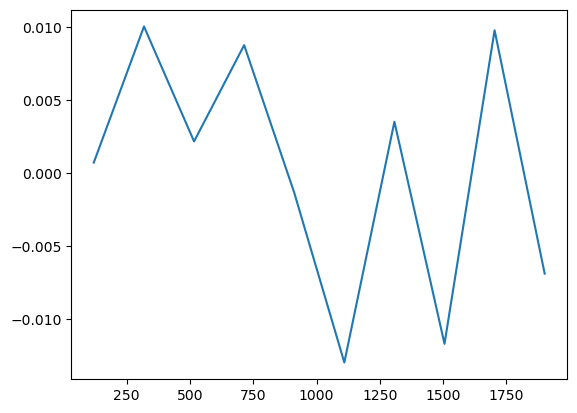

In [94]:
%matplotlib inline

fig,ax=plt.subplots()
ax.plot(binner.bin_mids, binner.bin_mids**2*binner(cl_dg_planck))